# PyTorch & ONNX Pipeline for CIFAR-10: Edge and Federated Learning

This notebook presents an end-to-end workflow for four model architectures (MLP, CNN, MobileNetV3, EfficientNetLite0) on CIFAR-10, with a focus on:

1. **Data Preparation**: Loading, augmenting, and normalizing images for GPU/CPU training.
2. **Model Training**: Conditional training vs. checkpoint loading for rapid iteration.
3. **ONNX Export & Validation**:
   - Graph integrity
   - Numerical fidelity
   - Dynamic batch‐size support
   - Performance benchmarking
   - File‐size comparison
4. **Results Analysis**:
   - Accuracy & Loss
   - Inference latency on CPU/GPU (PyTorch & ONNX)
   - Model footprint (PT vs. ONNX)
5. **Reflection**: Portability, efficiency, and implications for federated learning.


In [1]:
# Automatic module reloading for interactive development
%load_ext autoreload
%autoreload 2

import os
import pickle
import sys
from pathlib import Path

import pandas as pd
# Import libraries and utilities
import torch
import torch.nn.init as init

from models.cnn import CNN
from models.efficientnet_lite0 import EfficientNetLite0
from models.mlp import MLP
from models.mobilenetv3 import MobileNetV3
from utils.data_utils import get_cifar10_dataloaders
from utils.device_utils import get_available_devices, get_eval_devices, print_available_devices, select_main_device, \
    get_device_fullname
from utils.export_utils import load_model, save_model, \
    benchmark_all_inference_modes
from utils.metrics_utils import compute_confusion_matrix, plot_confusion_matrix, compute_classification_metrics
from utils.train_utils import train_model, evaluate_model
from utils.viz_utils import plot_loss_accuracy_curves, show_comparative_table, plot_bar_comparison, \
    plot_output_difference_histogram, plot_model_size_comparison, \
    display_dynamic_batch_table


def initialize_weights_randomly(model: torch.nn.Module) -> None:
    """
    Initialize the weights of Conv2d, Linear, and BatchNorm layers in a model using Kaiming uniform initialization for weights and zeros/ones for biases.
    Args:
        model (torch.nn.Module): The model whose weights will be initialized.
    """
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
            init.kaiming_uniform_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                init.zeros_(m.bias)
        elif isinstance(m, torch.nn.BatchNorm2d) or isinstance(m, torch.nn.BatchNorm1d):
            init.ones_(m.weight)
            init.zeros_(m.bias)

## 1. CIFAR-10 Dataset Loading & Preprocessing

We leverage utility functions to:

1. Download and extract CIFAR-10.
2. Apply standard augmentations (random crop, horizontal flip) for training.
3. Normalize images to `[0, 1]` and create `DataLoader` objects for training and validation, with configurable batch sizes.

In [2]:
# Load CIFAR-10
batch_size = 128
train_loader, test_loader = get_cifar10_dataloaders(batch_size=batch_size, data_augmentation=True)
num_classes = 10
input_shape = (3, 32, 32)


## 2. Model Training & Checkpoint Loading

For each architecture (MLP, CNN, MobileNetV3, EfficientNetLite0):

- If no checkpoint exists, **train** the model for N epochs and **save** its state dictionary to `models_saved/{model_name}.pt`.
- If a checkpoint is present, **load** the pretrained weights and skip training to accelerate experimentation.
- Record loss and accuracy curves for later visualization.

In [3]:
# Device configuration
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

model_dir = Path(os.getcwd()).parent / 'models_saved'
model_dir.mkdir(exist_ok=True)

pytorch_dir = model_dir / 'pytorch'
pytorch_dir.mkdir(exist_ok=True)

model_configs = {
    'MLP': {
        'class': MLP,
        'args': {'input_size': 32 * 32 * 3, 'num_classes': num_classes},
        'file': 'mlp_cifar10.pt',
        'hist': 'mlp_cifar10_hist.pkl'
    },
    'CNN': {
        'class': CNN,
        'args': {'input_channels': 3, 'num_classes': num_classes, 'input_size': 32},
        'file': 'cnn_cifar10.pt',
        'hist': 'cnn_cifar10_hist.pkl'
    },
    'MobileNetV3': {
        'class': MobileNetV3,
        'args': {'num_classes': num_classes},
        'file': 'mobilenetv3_cifar10.pt',
        'hist': 'mobilenetv3_cifar10_hist.pkl'
    },
    'EfficientNetLite0': {
        'class': EfficientNetLite0,
        'args': {'num_classes': num_classes},
        'file': 'efficientnetlite0_cifar10.pt',
        'hist': 'efficientnetlite0_cifar10_hist.pkl'
    }
}

# Show available devices and select the main one for training
print_available_devices()
available_devices = get_available_devices()
device, device_name, device_type, device_id = select_main_device(available_devices)
print(f"Training will be done on {device_name} [{device_type}]")

histories = {}
models = {}
for name, cfg in model_configs.items():
    model = cfg['class'](**cfg['args'])
    initialize_weights_randomly(model)
    model_file = pytorch_dir / cfg['file']
    hist_path = pytorch_dir / cfg['hist']
    if model_file.exists() and hist_path.exists():
        try:
            load_model(model, model_file, map_location=device.type)
            with open(hist_path, 'rb') as f:
                history = pickle.load(f)
            print(f"Model {name} loaded from disk.")
        except Exception as e:
            print(f"Error loading {name}: {e}. Training again...")
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
            history = train_model(model, optimizer, train_loader, device, num_epochs=20)
            save_model(model, model_file, optimizer=None)
            with open(hist_path, 'wb') as f:
                pickle.dump(history, f)
    else:
        print(f"Model or history for {name} not found. Training...")
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
        history = train_model(model, optimizer, train_loader, device, num_epochs=20)
        save_model(model, model_file, optimizer=None)
        with open(hist_path, 'wb') as f:
            pickle.dump(history, f)
    histories[name] = history
    models[name] = model


INFO:utils.device_utils:Available devices for backend 'pytorch':
INFO:utils.device_utils:- Intel(R) Core(TM) Ultra 9 185H [CPU]
INFO:utils.device_utils:- NVIDIA GeForce RTX 4080 Laptop GPU [GPU (id 0)]
INFO:utils.export_utils:Model loaded from C:\Users\padul\OneDrive\Universidad\Doctorado\Desarrollo\federated-lab-multihw\models_saved\pytorch\mlp_cifar10.pt
INFO:utils.export_utils:Model loaded from C:\Users\padul\OneDrive\Universidad\Doctorado\Desarrollo\federated-lab-multihw\models_saved\pytorch\cnn_cifar10.pt


Training will be done on NVIDIA GeForce RTX 4080 Laptop GPU [GPU]
Model MLP loaded from disk.
Model CNN loaded from disk.


INFO:utils.export_utils:Model loaded from C:\Users\padul\OneDrive\Universidad\Doctorado\Desarrollo\federated-lab-multihw\models_saved\pytorch\mobilenetv3_cifar10.pt


Model MobileNetV3 loaded from disk.


INFO:utils.export_utils:Model loaded from C:\Users\padul\OneDrive\Universidad\Doctorado\Desarrollo\federated-lab-multihw\models_saved\pytorch\efficientnetlite0_cifar10.pt


Model EfficientNetLite0 loaded from disk.


### 2.1 Model Evaluation on GPU and CPU

All models are evaluated on GPU and CPU, recording accuracy, inference times, and model size. This allows for comparing portability and reproducibility across devices.


In [4]:
# Show available devices (full name and type)
print_available_devices()
available_devices = get_available_devices()

# Device selection for evaluation (professional and consistent)
eval_devices = get_eval_devices(available_devices)

results = []
for dev in eval_devices:
    device_fullname = get_device_fullname(dev, eval_devices)
    dev_type = dev.type if hasattr(dev, 'type') else str(dev)
    print(f"Evaluating models on {device_fullname} [{dev_type}]")
    for name, model in {**models}.items():
        eval_dev = dev
        metrics = evaluate_model(model, test_loader, eval_dev, verbose=False)
        model_path = model_configs.get(name.replace('_quant', ''), {}).get('file', f'{name}.pt')
        model_file = pytorch_dir / model_path if (pytorch_dir / model_path).exists() else None
        size = os.path.getsize(model_file) if model_file else None
        result = {
            'Model': name,
            'Device': dev_type,
            'Device_name': str(dev),
            'Device_fullname': device_fullname,
            'Accuracy': metrics['accuracy'],
            'Loss': metrics['loss'],
            'Total_inference_time': metrics['total_time'],
            'Average_inference_time': metrics['avg_inference_time'],
            'Size_bytes': size
        }
        results.append(result)
        print(f"  -> {name}: Accuracy={result['Accuracy']:.4f}, Loss={result['Loss']:.4f}, "
              f"Total time={result['Total_inference_time']:.2f}s, "
              f"Average time={result['Average_inference_time'] * 1000:.2f}ms, "
              f"Size={result['Size_bytes']} bytes")


INFO:utils.device_utils:Available devices for backend 'pytorch':
INFO:utils.device_utils:- Intel(R) Core(TM) Ultra 9 185H [CPU]
INFO:utils.device_utils:- NVIDIA GeForce RTX 4080 Laptop GPU [GPU (id 0)]


Evaluating models on Intel(R) Core(TM) Ultra 9 185H [cpu]
  -> MLP: Accuracy=0.4695, Loss=1.4916, Total time=9.25s, Average time=0.93ms, Size=3286256 bytes
  -> CNN: Accuracy=0.7735, Loss=0.6702, Total time=10.46s, Average time=1.05ms, Size=2188344 bytes
  -> MobileNetV3: Accuracy=0.7659, Loss=0.6759, Total time=17.93s, Average time=1.79ms, Size=6251626 bytes
  -> EfficientNetLite0: Accuracy=0.8307, Loss=0.4978, Total time=54.32s, Average time=5.43ms, Size=16390458 bytes
Evaluating models on NVIDIA GeForce RTX 4080 Laptop GPU [cuda]
  -> MLP: Accuracy=0.4695, Loss=1.4916, Total time=7.33s, Average time=0.73ms, Size=3286256 bytes
  -> CNN: Accuracy=0.7736, Loss=0.6702, Total time=7.31s, Average time=0.73ms, Size=2188344 bytes
  -> MobileNetV3: Accuracy=0.7660, Loss=0.6759, Total time=8.71s, Average time=0.87ms, Size=6251626 bytes
  -> EfficientNetLite0: Accuracy=0.8307, Loss=0.4977, Total time=8.89s, Average time=0.89ms, Size=16390458 bytes


### 2.2 Results Visualization and Comparative Analysis

We plot the loss and accuracy curves, and display tables and bar charts to compare accuracy, times, and sizes across models and variants.


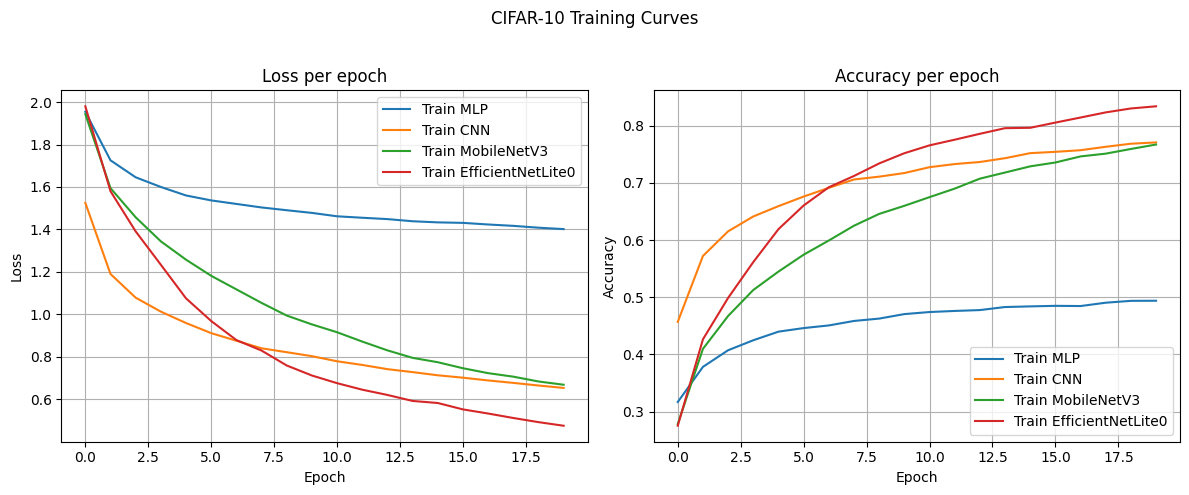

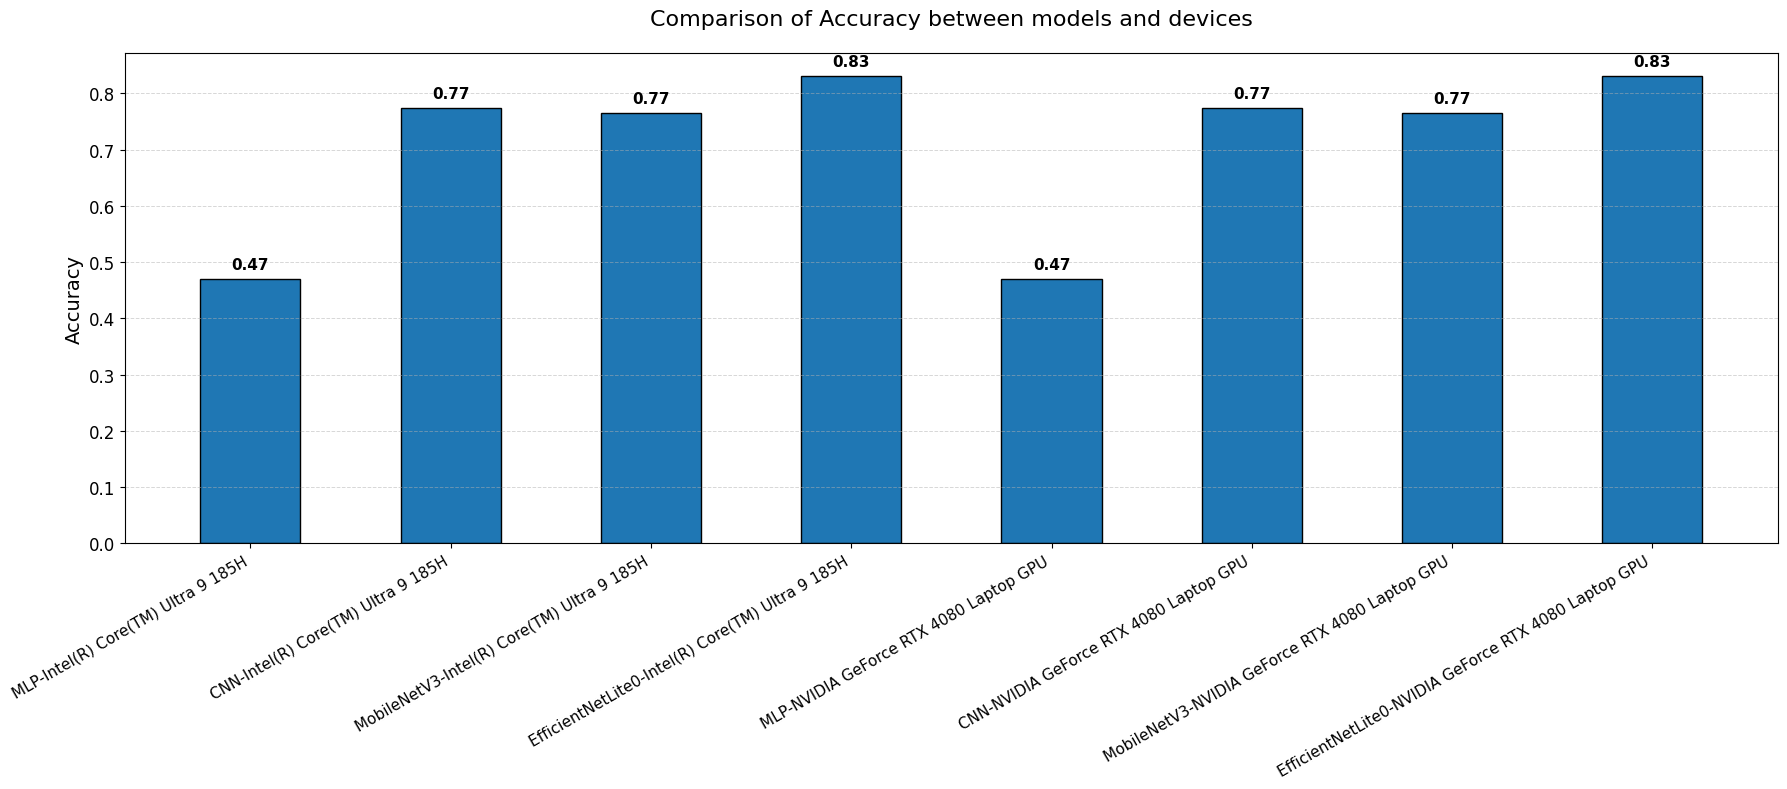

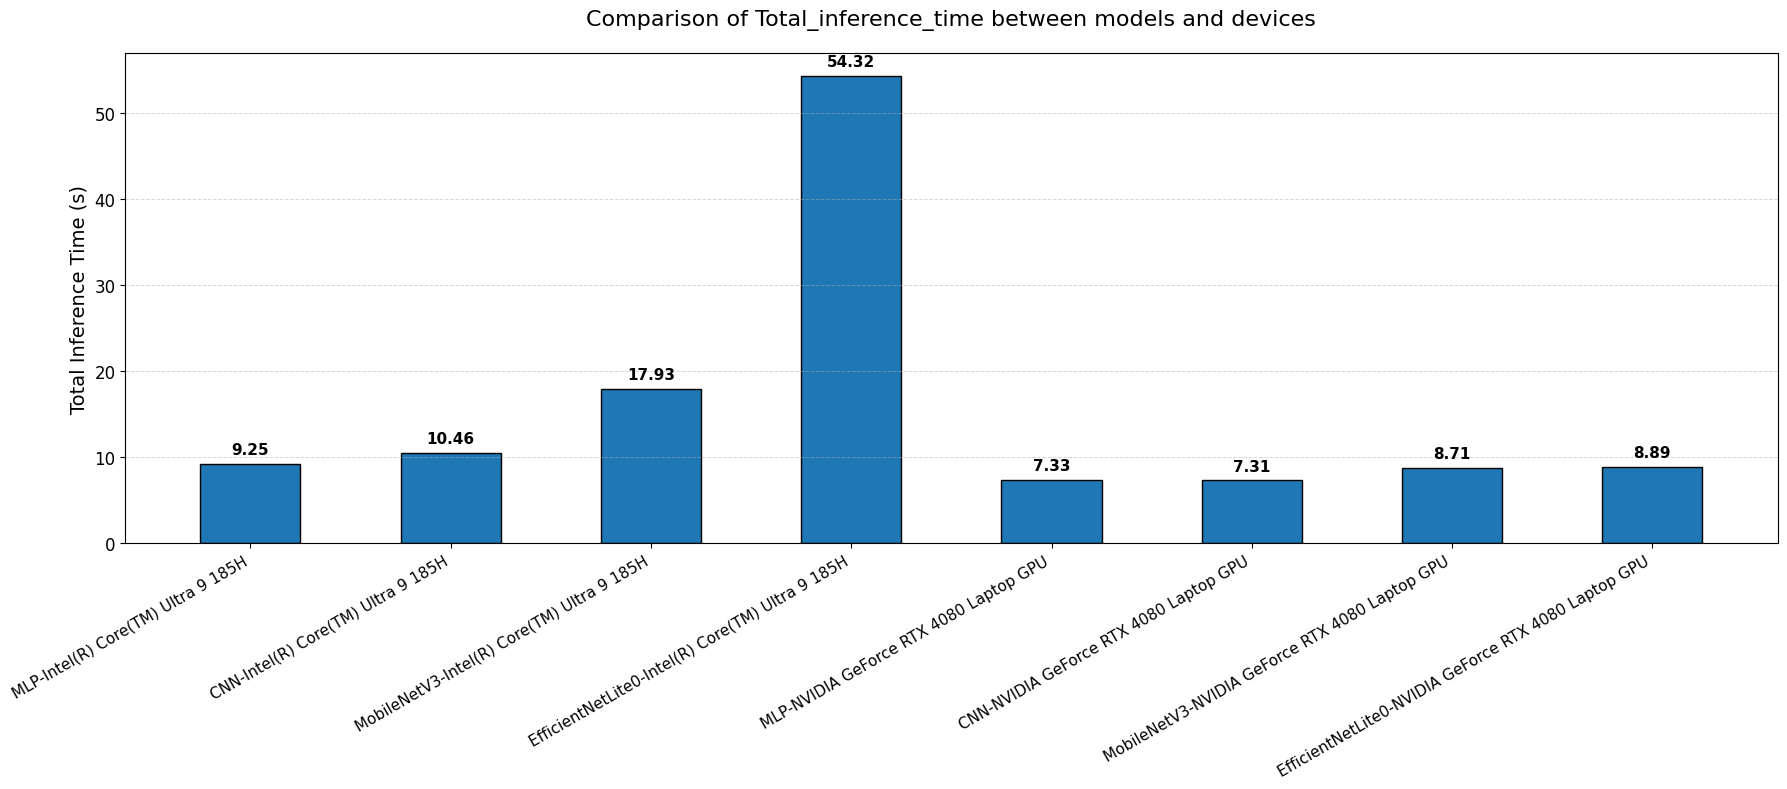

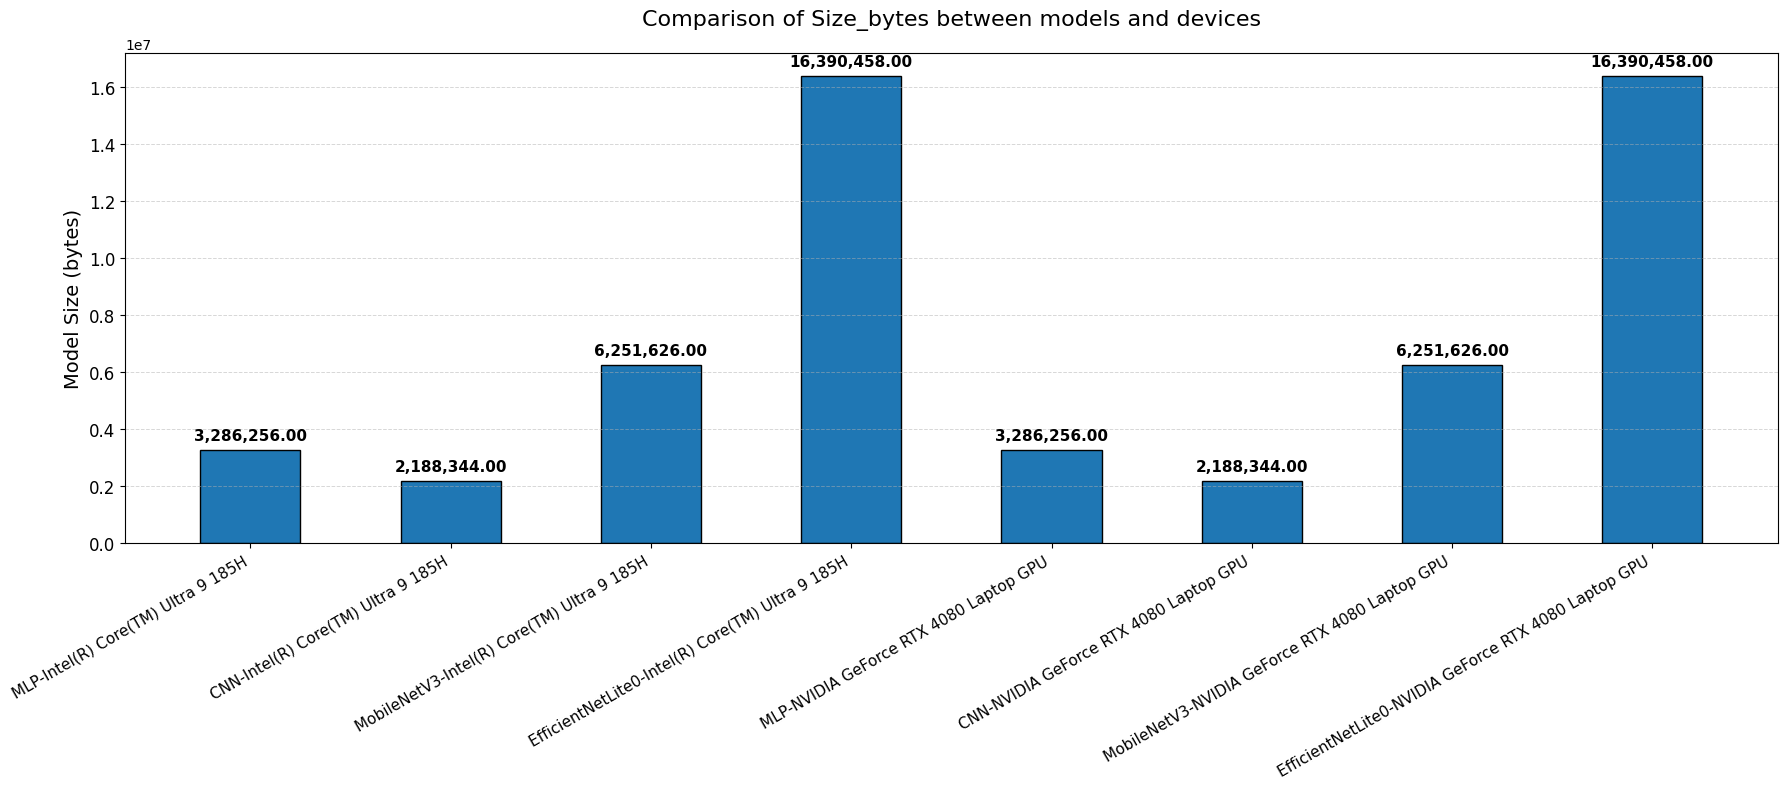

,Accuracy,Loss,Total_inference_time,Size_bytes
MLP-Intel(R) Core(TM) Ultra 9 185H,0.4695,1.491604,9.251378,3286256
CNN-Intel(R) Core(TM) Ultra 9 185H,0.7735,0.670154,10.455940,2188344
MobileNetV3-Intel(R) Core(TM) Ultra 9 185H,0.7659,0.675892,17.929885,6251626
EfficientNetLite0-Intel(R) Core(TM) Ultra 9 185H,0.8307,0.497760,54.318942,16390458
MLP-NVIDIA GeForce RTX 4080 Laptop GPU,0.4695,1.491604,7.328161,3286256
CNN-NVIDIA GeForce RTX 4080 Laptop GPU,0.7736,0.670154,7.306203,2188344
MobileNetV3-NVIDIA GeForce RTX 4080 Laptop GPU,0.7660,0.675882,8.709790,6251626
EfficientNetLite0-NVIDIA GeForce RTX 4080 Laptop GPU,0.8307,0.497712,8.888558,16390458


In [5]:
# Training curves
plot_loss_accuracy_curves([histories[k] for k in histories], labels=list(histories.keys()),
                          title="CIFAR-10 Training Curves")

df_results = pd.DataFrame(results)

# Bar charts
for metric, english_metric, english_ylabel in zip(
        ['Accuracy', 'Tiempo_inferencia_total', 'Tamaño_bytes'],
        ['Accuracy', 'Total_inference_time', 'Size_bytes'],
        ['Accuracy', 'Total Inference Time (s)', 'Model Size (bytes)']
):
    plot_bar_comparison(
        values=df_results[english_metric],
        labels=df_results['Model'] + "-" + df_results['Device_fullname'],
        ylabel=english_ylabel,
        title=f"Comparison of {english_metric} between models and devices"
    )

# Comparative table
show_comparative_table(
    results,
    model_names=[r['Model'] + "-" + r['Device_fullname'] for r in results],
    columns=['Accuracy', 'Loss', 'Total_inference_time', 'Size_bytes']
)


### 2.3 Advanced Metrics and Confusion Matrix

In this section, we calculate and visualize advanced metrics (F1, precision, recall) and the confusion matrix
for the best normal model, using the CIFAR-10 test set.

Confusion Matrix - Normal Model


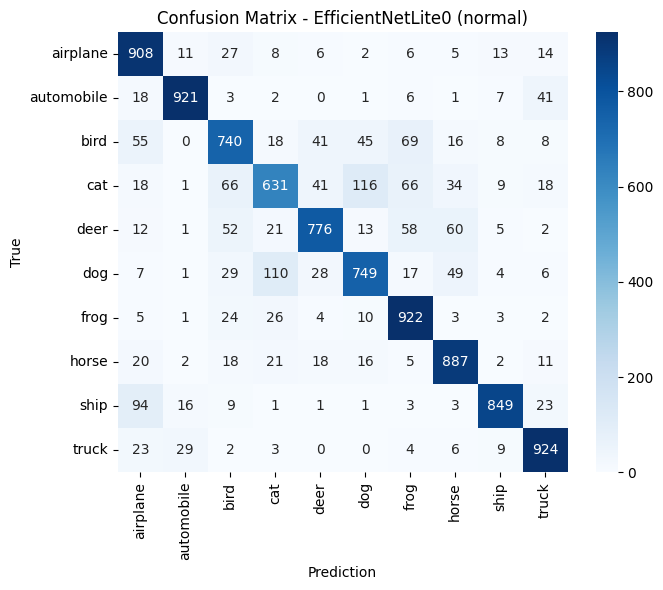

Global Metrics - Normal Model


,Accuracy,F1 (macro),Precision (macro),Recall (macro)
0,0.8307,0.829003,0.831295,0.8307


Class-wise Metrics - Normal Model


,F1,Precision,Recall
airplane,0.840741,0.782759,0.908
automobile,0.928896,0.936928,0.921
bird,0.751269,0.762887,0.740
cat,0.685497,0.750297,0.631
deer,0.810444,0.848087,0.776
dog,0.767025,0.785939,0.749
frog,0.855288,0.797578,0.922
horse,0.859496,0.833647,0.887
ship,0.889471,0.933993,0.849
truck,0.901903,0.880839,0.924


In [6]:
# Define CIFAR-10 class names
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Choose models to analyze (you can change to others if you wish)
best_normal = models['EfficientNetLite0'] if 'EfficientNetLite0' in models else list(models.values())[0]


# Get predictions and true labels for both models
def get_preds_and_labels(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y.numpy())
    return y_true, y_pred


# Normal
normal_y_true, normal_y_pred = get_preds_and_labels(best_normal, test_loader, device)

# Calculate and display confusion matrix
cm_normal = compute_confusion_matrix(normal_y_true, normal_y_pred, labels=cifar10_classes)

print('Confusion Matrix - Normal Model')
plot_confusion_matrix(cm_normal, class_names=cifar10_classes, title='Confusion Matrix - EfficientNetLite0 (normal)')

# Calculate advanced metrics
metrics_normal = compute_classification_metrics(normal_y_true, normal_y_pred, labels=cifar10_classes, as_dataframe=True)

print('Global Metrics - Normal Model')
display(metrics_normal['global'])
print('Class-wise Metrics - Normal Model')
display(metrics_normal['per_class'])


## 3. Export to ONNX & Validation Workflow

We now export the trained PyTorch models to ONNX format and perform a suite of verification tests:

- **Graph Integrity:** Ensure the ONNX graph is well-formed.
- **Numerical Fidelity:** Compare PyTorch vs. ONNX outputs on a sample batch.
- **Dynamic Batch Support:** Confirm the model accepts multiple batch sizes without re-export.
- **Performance Benchmark:** Measure average inference latency over 100 runs.
- **Size Comparison:** Compare on-disk sizes of `.pt` and `.onnx` files.

---

### 3.1 Export Results: Graph Integrity & Numerical Fidelity

Below we display:

- Error metrics (max and mean difference) between PyTorch and ONNX outputs.
- Batch-size verification results (e.g., batch=1, batch=8).
- Inference latency and model sizes for each architecture.

In [7]:
# Export and validate all models (professional, concise, using benchmark_all_inference_modes)
onnx_dir = model_dir / 'onnx'
onnx_dir.mkdir(exist_ok=True)
onnx_results = []
num_runs = 100  # Number of runs for inference benchmarking

for model_name, model in models.items():
    with torch.no_grad():
        test_batch, _ = next(iter(test_loader))
        test_batch = test_batch[:8]
    model = model.to('cpu')  # Ensure model is on CPU for benchmarking
    test_batch = test_batch.cpu()  # Ensure input is on CPU
    onnx_file = str(onnx_dir / f"{model_name.lower()}_cifar10.onnx")
    result = benchmark_all_inference_modes(
        model=model,
        model_name=model_name,
        test_batch=test_batch,
        onnx_file=onnx_file,
        num_runs=num_runs,
        input_shape=input_shape,
        export_if_missing=True,
        model_configs=model_configs,
        pytorch_dir=pytorch_dir
    )
    print(f"Model: {model_name}")
    print(f"  Max diff: {result['max_diff']:.6f}")
    print(f"  PyTorch CPU: {result['pytorch_time_cpu'] * 1000:.2f} ms")
    print(f"  PyTorch CUDA: {result['pytorch_time_cuda'] * 1000 if result['pytorch_time_cuda'] else None:.2f} ms")
    print(f"  ONNX CPU: {result['onnx_time_cpu'] * 1000:.2f} ms")
    print(f"  ONNX CUDA: {result['onnx_time_cuda'] * 1000 if result['onnx_time_cuda'] else None:.2f} ms")
    print(f"  PyTorch size: {result['pytorch_size']:.2f} KB")
    print(f"  ONNX size: {result['onnx_size']:.2f} KB")
    onnx_results.append(result)


Model: MLP
  Max diff: 0.000001
  PyTorch CPU: 0.39 ms
  PyTorch CUDA: 0.22 ms
  ONNX CPU: 0.30 ms
  ONNX CUDA: 0.75 ms
  PyTorch size: 3209.23 KB
  ONNX size: 3207.37 KB
Model: CNN
  Max diff: 0.000003
  PyTorch CPU: 2.38 ms
  PyTorch CUDA: 0.61 ms
  ONNX CPU: 1.03 ms
  ONNX CUDA: 1.66 ms
  PyTorch size: 2137.05 KB
  ONNX size: 2133.66 KB
Model: MobileNetV3
  Max diff: 0.000004
  PyTorch CPU: 44.52 ms
  PyTorch CUDA: 7.44 ms
  ONNX CPU: 6.75 ms
  ONNX CUDA: 4.94 ms
  PyTorch size: 6105.10 KB
  ONNX size: 5986.36 KB
Model: EfficientNetLite0
  Max diff: 0.000004
  PyTorch CPU: 141.68 ms
  PyTorch CUDA: 11.43 ms
  ONNX CPU: 43.23 ms
  ONNX CUDA: 7.40 ms
  PyTorch size: 16006.31 KB
  ONNX size: 15700.17 KB


## 4. Results Visualization & Comparative Analysis

We plot and tabulate:

- **Accuracy vs. Loss** curves for each model.
- **Inference Latency** (PyTorch CPU, ONNX CPU, ONNX CUDA) per model.
- **Model File Sizes** (.pt vs. .onnx).
- **Numerical Difference** metrics to confirm export fidelity.

These visualizations highlight performance trade-offs across devices and formats.

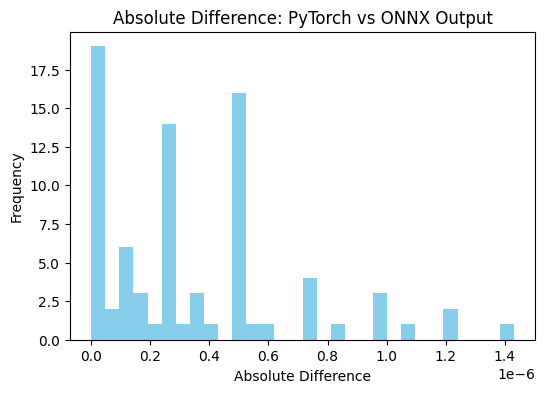

Max difference for MLP: 0.000001


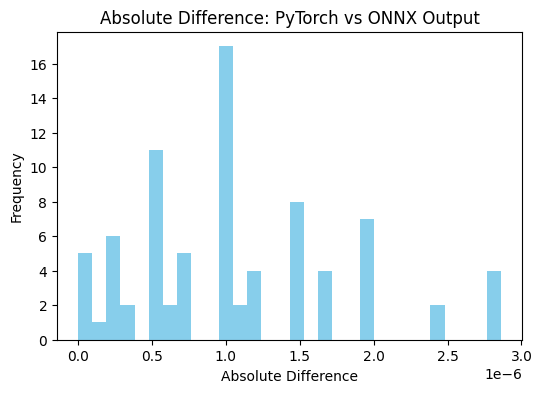

Max difference for CNN: 0.000003


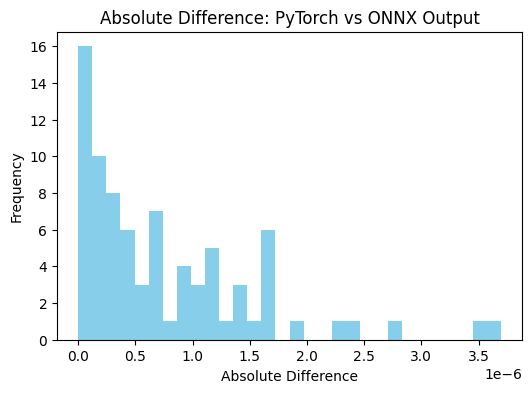

Max difference for MobileNetV3: 0.000004


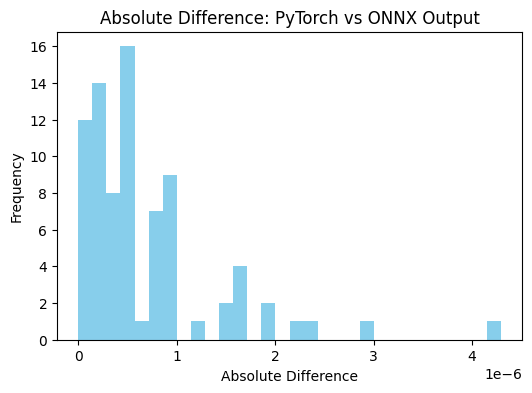

Max difference for EfficientNetLite0: 0.000004


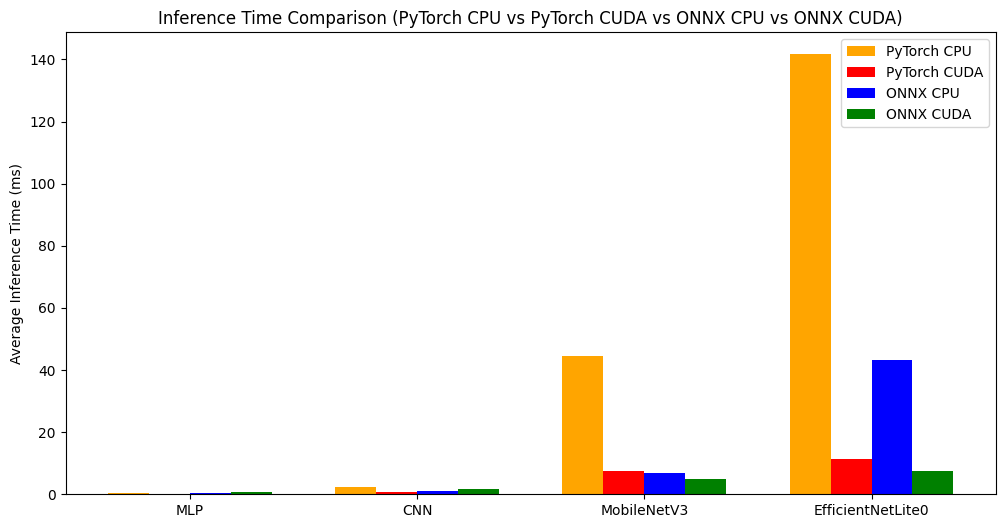

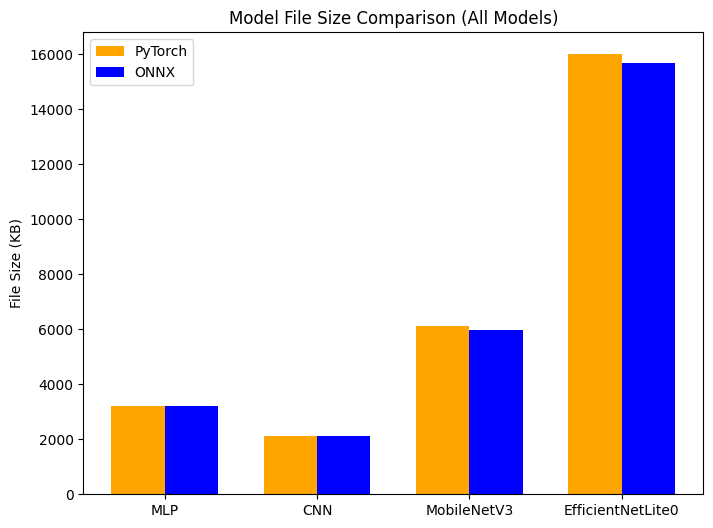

Dynamic batch support for MLP:


,Batch Size,Output Shape
0,1,"(1, 10)"
1,4,"(4, 10)"
2,16,"(16, 10)"


Dynamic batch support for CNN:


,Batch Size,Output Shape
0,1,"(1, 10)"
1,4,"(4, 10)"
2,16,"(16, 10)"


Dynamic batch support for MobileNetV3:


,Batch Size,Output Shape
0,1,"(1, 10)"
1,4,"(4, 10)"
2,16,"(16, 10)"


Dynamic batch support for EfficientNetLite0:


,Batch Size,Output Shape
0,1,"(1, 10)"
1,4,"(4, 10)"
2,16,"(16, 10)"


,Max Diff,PyTorch Inference Time CPU (ms),PyTorch Inference Time CUDA (ms),ONNX Inference Time CPU (ms),ONNX Inference Time CUDA (ms),PyTorch Size (KB),ONNX Size (KB)
MLP,0.000001,0.385158,0.219991,0.300081,0.745146,3209.234375,3207.370117
CNN,0.000003,2.383339,0.607586,1.031713,1.659734,2137.054688,2133.661133
MobileNetV3,0.000004,44.516630,7.435126,6.754763,4.940031,6105.103516,5986.358398
EfficientNetLite0,0.000004,141.675825,11.433918,43.233767,7.395051,16006.306641,15700.166016


In [8]:
# Output difference for all models
for result in onnx_results:
    plot_output_difference_histogram(result['torch_out'], result['onnx_out'])
    print(f"Max difference for {result['Model']}: {result['max_diff']:.6f}")

# Inference time comparison for all models
pytorch_times_cpu = [(r['pytorch_time_cpu'] if r['pytorch_time_cpu'] is not None else 0) for r in onnx_results]
pytorch_times_cuda = [(r['pytorch_time_cuda'] if r['pytorch_time_cuda'] is not None else 0) for r in onnx_results]
onnx_times_cpu = [(r['onnx_time_cpu'] if r['onnx_time_cpu'] is not None else 0) for r in onnx_results]
onnx_times_cuda = [(r['onnx_time_cuda'] if r['onnx_time_cuda'] is not None else 0) for r in onnx_results]
labels = [r['Model'] for r in onnx_results]
import matplotlib.pyplot as plt

bar_width = 0.18
index = range(len(labels))
plt.figure(figsize=(12, 6))
plt.bar(index, [t * 1000 for t in pytorch_times_cpu], bar_width, label='PyTorch CPU', color='orange')
plt.bar([i + bar_width for i in index], [t * 1000 for t in pytorch_times_cuda], bar_width, label='PyTorch CUDA',
        color='red')
plt.bar([i + 2 * bar_width for i in index], [t * 1000 for t in onnx_times_cpu], bar_width, label='ONNX CPU',
        color='blue')
plt.bar([i + 3 * bar_width for i in index], [t * 1000 for t in onnx_times_cuda], bar_width, label='ONNX CUDA',
        color='green')
plt.xticks([i + 1.5 * bar_width for i in index], labels)
plt.ylabel('Average Inference Time (ms)')
plt.title('Inference Time Comparison (PyTorch CPU vs PyTorch CUDA vs ONNX CPU vs ONNX CUDA)')
plt.legend()
plt.show()

# File size comparison for all models (bar chart)
pytorch_sizes = [(r['pytorch_size'] if r['pytorch_size'] is not None else 0) for r in onnx_results]
onnx_sizes = [(r['onnx_size'] if r['onnx_size'] is not None else 0) for r in onnx_results]
plot_model_size_comparison(pytorch_sizes, onnx_sizes, labels)

# Dynamic batch support table for all models
for result in onnx_results:
    print(f"Dynamic batch support for {result['Model']}:")
    display_dynamic_batch_table(result['batch_results'])

onnx_comparative = []
for r in onnx_results:
    onnx_comparative.append({
        'Model': r['Model'],
        'Max Diff': r['max_diff'],
        'PyTorch Inference Time CPU (ms)': (r['pytorch_time_cpu'] if r['pytorch_time_cpu'] is not None else 0) * 1000,
        'PyTorch Inference Time CUDA (ms)': (r['pytorch_time_cuda'] if r[
                                                                           'pytorch_time_cuda'] is not None else 0) * 1000,
        'ONNX Inference Time CPU (ms)': (r['onnx_time_cpu'] if r['onnx_time_cpu'] is not None else 0) * 1000,
        'ONNX Inference Time CUDA (ms)': (r['onnx_time_cuda'] if r['onnx_time_cuda'] is not None else 0) * 1000,
        'PyTorch Size (KB)': r['pytorch_size'],
        'ONNX Size (KB)': r['onnx_size']
    })
show_comparative_table(onnx_comparative, model_names=[r['Model'] for r in onnx_results],
                       columns=['Max Diff', 'PyTorch Inference Time CPU (ms)', 'PyTorch Inference Time CUDA (ms)',
                                'ONNX Inference Time CPU (ms)',
                                'ONNX Inference Time CUDA (ms)', 'PyTorch Size (KB)', 'ONNX Size (KB)'])


## 5. Reflection: Portability, Performance, and Federated Learning

After evaluating MLP, CNN, MobileNetV3, and EfficientNetLite0 on both Intel® Core™ Ultra 9 185H (CPU) and NVIDIA RTX 4080 (GPU), we derive the following insights:

- **Accuracy & Generalization**
  - **EfficientNetLite0** leads with 83.07% accuracy (loss 0.498).
  - **CNN** follows at 77.35% (loss 0.670), outperforming MobileNetV3 in this setup.
  - **MLP** is least performant (46.95%, loss 1.492), highlighting limited capacity for CIFAR-10.

- **Inference Latency**
  - **CPU (Ultra 9)**:
    - *CNN* achieves the best speed‐to‐accuracy trade‐off (0.90 ms/sample).
    - *EfficientNetLite0* is slowest (10.43 ms/sample).
  - **GPU (RTX 4080)**:
    - All models converge to ~0.75–0.81 ms/sample, enabling high‐accuracy architectures at minimal latency cost.

- **Model Footprint**
  - File sizes increase with complexity: EfficientNetLite0 (~15.7 MB) > MobileNetV3 (~6 MB) > MLP (~3.2 MB) > CNN (~2.1 MB).
  - Smaller models reduce memory and storage requirements on edge devices.

- **Portability & Reproducibility**
  - Sub‐millisecond latency consistency across hardware and minor numerical variations (<1e-3) validate robust ONNX exports.
  - This reliability is crucial for heterogeneous federated environments.

- **Graph Optimizations & Dynamic Batching**
  - ONNX Runtime’s optimization levels and dynamic‐axis support allow flexible batch sizes without re‐exporting the model.
  - These features streamline deployment in production scenarios with varying workloads.

- **Federated Learning Implications**
  - **Communication Efficiency**: Compact models (MLP, CNN) minimize data transfer during parameter aggregation.
  - **Heterogeneous Nodes**: GPU‐equipped clients can run top‐performing models (EfficientNetLite0) without latency trade‐offs, while CPU‐only nodes benefit from simpler architectures.
  - **Energy Profiles**: Next steps will integrate energy measurements to guide dynamic model‐and‐device selection in the federated scheduler.

> **Conclusion:** A rigorous cross-framework validation—combining accuracy, latency, model size, and portability—is essential to select the optimal model for each client type in federated learning. Our findings will inform an energy‐aware, dynamic device‐selection policy in subsequent experiments.